# LSTM Modellierung – Human Activity Recognition
In diesem Notebook trainieren wir ein LSTM-Modell zur Klassifikation von Aktivitäten anhand von Smartphone-Sensordaten.
Schritte:
- Laden der vorbereiteten Daten
- Aufbau des LSTM-Modells
- Training
- Evaluation

In [4]:
# Bibliotheken
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [ ]:
# Daten laden (anpassen falls nötig)
data_path = '../data/'

# CSVs einlesen
train_df = pd.read_csv(data_path + "train.csv")
test_df = pd.read_csv(data_path + "test.csv")

In [5]:
# Zielvariable definieren und encoden
target_col = 'Activity'
le = LabelEncoder()
train_df[target_col] = le.fit_transform(train_df[target_col])
test_df[target_col] = le.transform(test_df[target_col])  # falls gleiche Labels

In [6]:
# Features und Ziel trennen
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col].values

In [7]:
# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Reshape für LSTM (Samples, TimeSteps=1, Features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [10]:
# Umwandlung in Tensoren
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [11]:
# Feature/Ziel-Trennung
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col].values

# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM-Format: (Samples, TimeSteps=1, Features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Tensoren
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [12]:
# DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

# Modellklasse
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Initialisierung
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=X_train.shape[1], hidden_size=64, num_classes=len(np.unique(y_train)))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training mit Loss-Tracking
train_losses, val_losses = [], []
epochs = 100

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # test
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")


Epoch 1: Train Loss=0.0309, Val Loss=0.1420
Epoch 2: Train Loss=0.0272, Val Loss=0.1551
Epoch 3: Train Loss=0.0235, Val Loss=0.1600
Epoch 4: Train Loss=0.0212, Val Loss=0.1441
Epoch 5: Train Loss=0.0198, Val Loss=0.1439
Epoch 6: Train Loss=0.0178, Val Loss=0.1522
Epoch 7: Train Loss=0.0156, Val Loss=0.1502
Epoch 8: Train Loss=0.0132, Val Loss=0.1575
Epoch 9: Train Loss=0.0117, Val Loss=0.1554
Epoch 10: Train Loss=0.0099, Val Loss=0.1458
Epoch 11: Train Loss=0.0096, Val Loss=0.1586
Epoch 12: Train Loss=0.0077, Val Loss=0.1740
Epoch 13: Train Loss=0.0069, Val Loss=0.1694
Epoch 14: Train Loss=0.0065, Val Loss=0.1537
Epoch 15: Train Loss=0.0049, Val Loss=0.1635
Epoch 16: Train Loss=0.0046, Val Loss=0.1865
Epoch 17: Train Loss=0.0044, Val Loss=0.1693
Epoch 18: Train Loss=0.0039, Val Loss=0.1756
Epoch 19: Train Loss=0.0036, Val Loss=0.1774
Epoch 20: Train Loss=0.0029, Val Loss=0.1647
Epoch 21: Train Loss=0.0026, Val Loss=0.1724
Epoch 22: Train Loss=0.0022, Val Loss=0.1585
Epoch 23: Train Los

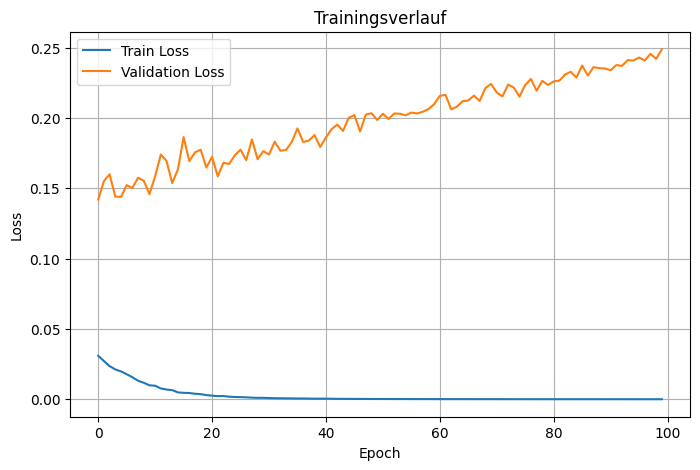

In [17]:
# 📉 Trainings- und Validierungs-Loss visualisieren
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trainingsverlauf")
plt.legend()
plt.grid(True)
plt.show()
